<a href="https://colab.research.google.com/github/floriyellin/GEOINT-demo/blob/main/GEOINT_demo_2024_grounded_sam_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Grounded SAM Inpainting Demo](https://github.com/floriyellin/GEOINT-demo/raw/main/GEOINT-Demo-2024.png)

## Why this project?

- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable **to detect and segment everything** with text inputs!



## Install

In [1]:
import os
HOME = os.getcwd()

In [2]:
%cd {HOME}

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd {HOME}/Grounded-Segment-Anything
!pip install -q -r requirements.txt

%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

%cd {HOME}/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd {HOME}/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1754, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1754 (delta 357), reused 352 (delta 329), pack-reused 1315
Receiving objects: 100% (1754/1754), 124.80 MiB | 23.69 MiB/s, done.
Resolving deltas: 100% (830/830), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 31.4 MB/s eta 0:00:00
  Installing build depe

## Imports

In [3]:
import os, sys
import argparse
import copy
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont, ImageFile
from torchvision.ops import box_convert
import supervision as sv
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import requests
import torch
from io import BytesIO
from huggingface_hub import hf_hub_download
%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate
import locale

locale.getpreferredencoding = lambda: "UTF-8"
ImageFile.LOAD_TRUNCATED_IMAGES = True

/content/GroundingDINO


# Download data and weights

In [4]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/108.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/122.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/1234.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/1235.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/1905.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/1916.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/2167.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/654.tif
!wget -q https://raw.githubusercontent.com/floriyellin/GEOINT-demo/main/945.tif

/content
/content/data


In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


## Load models

### Grounding DINO model

In [6]:
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
groundingdino_model = load_model(CONFIG_PATH, WEIGHTS_PATH)

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### SAM

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAM_NAME = 'sam_vit_h_4b8939.pth'
SAM_PATH = os.path.join(HOME, "weights", SAM_NAME)
sam_predictor = SamPredictor(build_sam(checkpoint=SAM_PATH).to(device))

## Inference

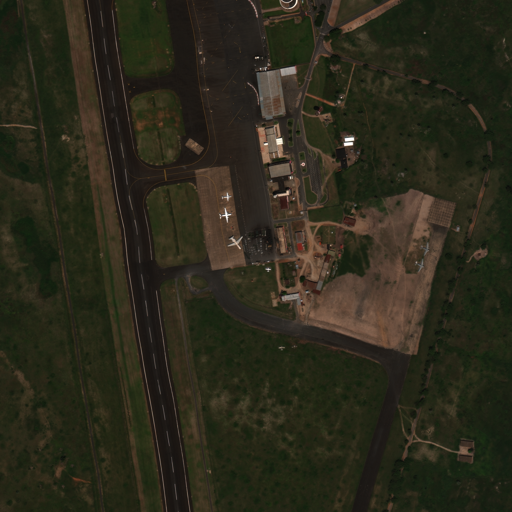

In [23]:
local_image_path = "654.tif"

image_source, image = load_image(os.path.join(HOME,"data",local_image_path))
Image.fromarray(image_source).resize((512,512))

## Grounding DINO for detection

In [24]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


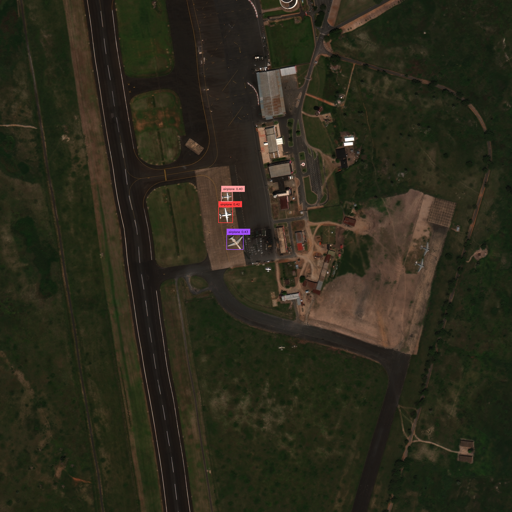

In [25]:
prompt = "airplane" # "building" "tree"

annotated_frame, detected_boxes = detect(image, text_prompt=prompt, model=groundingdino_model)
Image.fromarray(annotated_frame).resize((512,512))

## SAM for segmentation

In [26]:
from groundingdino.util import box_ops

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_one_mask(masks, image, random_color=True):
    mask = masks[0][0]
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


def draw_all_masks(masks, image, random_color=True):
    mask = sum([s[0] for s in masks])
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

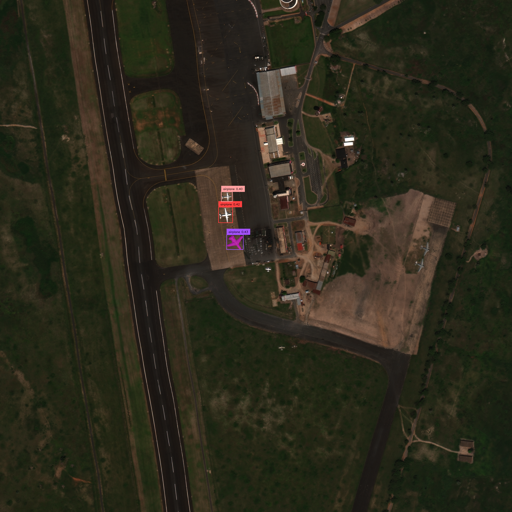

In [27]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_one_mask(segmented_frame_masks, annotated_frame)
Image.fromarray(annotated_frame_with_mask).resize((512,512))

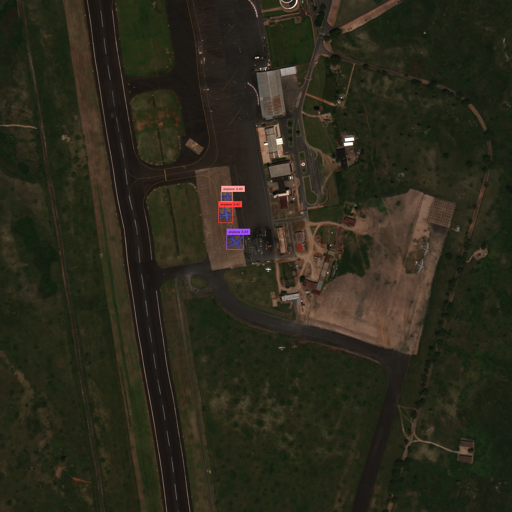

In [28]:
annotated_frame_with_mask = draw_all_masks(segmented_frame_masks, annotated_frame)
Image.fromarray(annotated_frame_with_mask).resize((512,512))

# Examples

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


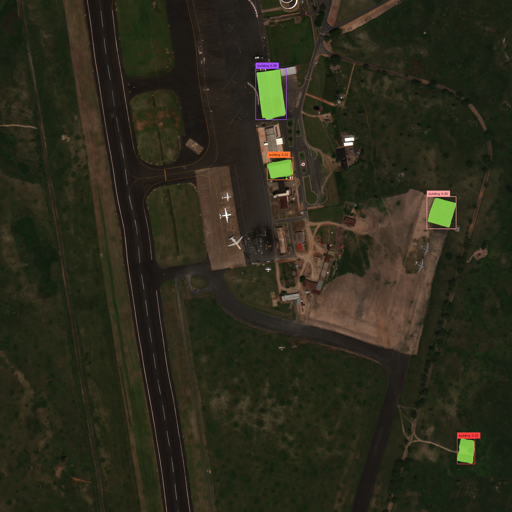

In [31]:
img_num = 654
caption = "building" # "airplane" "tree"
image_source, image = load_image(os.path.join(HOME,"data",f"{img_num}.tif"))
annotated_frame, detected_boxes = detect(image, text_prompt=caption, model=groundingdino_model)
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_all_masks(segmented_frame_masks, annotated_frame)
Image.fromarray(annotated_frame_with_mask).resize((512,512))

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


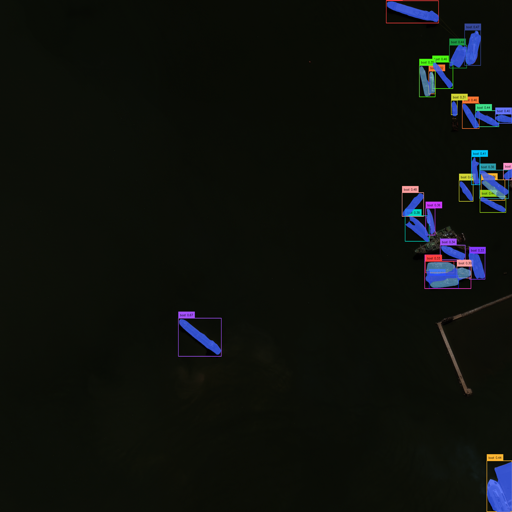

In [32]:
img_num = 1916
caption = "boat"
image_source, image = load_image(os.path.join(HOME,"data",f"{img_num}.tif"))
annotated_frame, detected_boxes = detect(image, text_prompt=caption, model=groundingdino_model)
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_all_masks(segmented_frame_masks, annotated_frame)
Image.fromarray(annotated_frame_with_mask).resize((512,512))

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


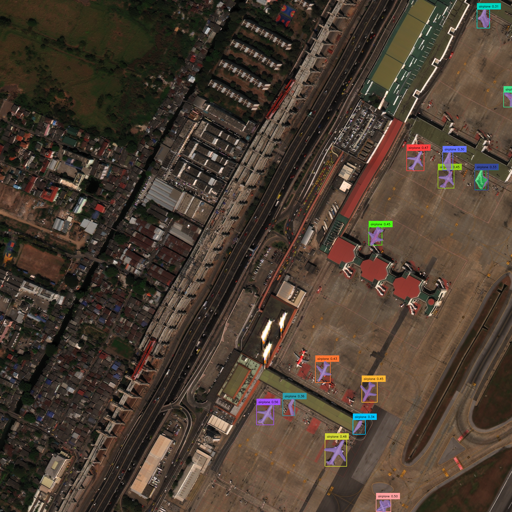

In [33]:
img_num = 2167
caption = "airplane"
image_source, image = load_image(os.path.join(HOME,"data",f"{img_num}.tif"))
annotated_frame, detected_boxes = detect(image, text_prompt=caption, model=groundingdino_model)
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_all_masks(segmented_frame_masks, annotated_frame)
Image.fromarray(annotated_frame_with_mask).resize((512,512))

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


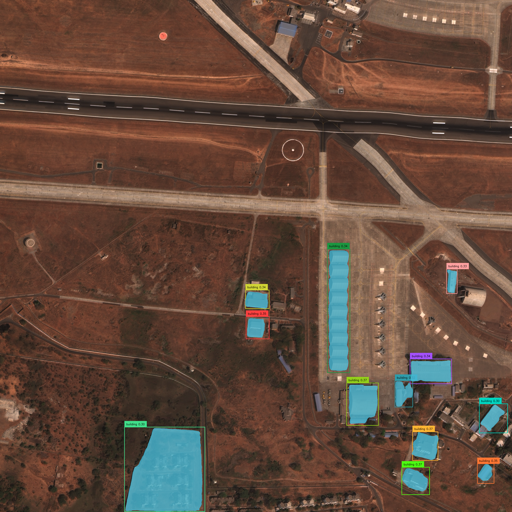

In [34]:
img_num = 1235
caption = "building"
image_source, image = load_image(os.path.join(HOME,"data",f"{img_num}.tif"))
annotated_frame, detected_boxes = detect(image, text_prompt=caption, model=groundingdino_model)
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_all_masks(segmented_frame_masks, annotated_frame)
Image.fromarray(annotated_frame_with_mask).resize((512,512))

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


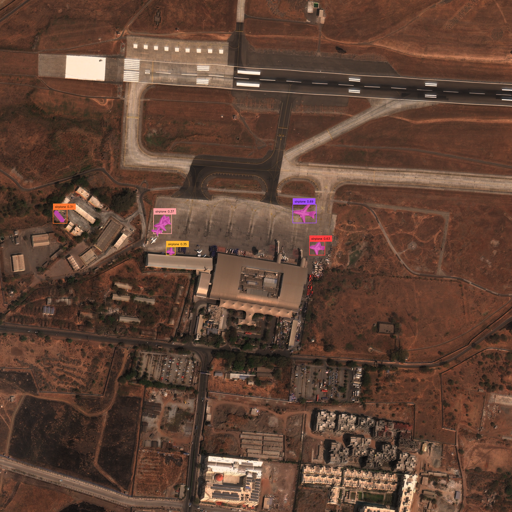

In [35]:
img_num = 1234
caption = "airplane"
image_source, image = load_image(os.path.join(HOME,"data",f"{img_num}.tif"))
annotated_frame, detected_boxes = detect(image, text_prompt=caption, model=groundingdino_model)
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_all_masks(segmented_frame_masks, annotated_frame)
Image.fromarray(annotated_frame_with_mask).resize((512,512))